Consider the problem defined as:

\begin{equation}
-\frac{\hbar^2}{2m} \frac{d^2  \psi}{dx^2}  + V(x) \psi =  E \psi
\end{equation}

where

*   $\hbar $ is the reduced Planck's constant
*   $m$ is the mass of particle
*  $\psi $ is the wavefunction (representing the eigenfunction/ eigenstate)
* $V(x) $ is the potential energy of the particle at any point $x$,
defined as
\begin{equation}
    V(x) = \frac{1}{2}m\omega^2x^2
\end{equation}
* $E$ is the energy of the particle (representing the eigenvalue of the equation)

Taking $l = 10$, $\hbar = 1, m = 1 $ and $\omega = 1$

In [1]:
#Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import grad
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim     #optimizer
import time
import copy
from torch.optim.lr_scheduler import CosineAnnealingLR
import math

torch.manual_seed(1234)

np.random.seed(1234)

#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device.type == 'cuda':
  print(torch.cuda.get_device_name(0))

#!pip install pyDOE
from pyDOE import lhs #latin hypercube sampling

cuda
NVIDIA RTX A6000


In [2]:
#Automatic differentiation in pytorch
def dfx(f, x):
    grads = []
    for i in range(f.shape[1]):  # iterate over columns
        grad_outputs = torch.zeros_like(f)
        grad_outputs[:, i] = 1.0
        df_i = grad(f, x, grad_outputs=grad_outputs, create_graph=True)[0]  # (n,1)
        grads.append(df_i.squeeze(-1))  # Remove extra dim to get (n,)
    return torch.stack(grads, dim=1)  # shape: (n, k)

In [3]:
#Defining the hyperparameters

class config:
    def __init__(self):
        self.t0 = -10
        self.tf = 10
        self.xbc = 0
        self.eig_num = 5
        self.col_pts = 200
        self.layers = [1,100,100,self.eig_num]
        self.epochs = 10000
        self.w0 = 3 #Fo Siren initialization principle

cfg = config()

### The NN Module

In [4]:
#Defining the NN architecture without symmetry
class gaussqNN(torch.nn.Module):
  def __init__(self,cfg):
    super(gaussqNN,self).__init__()
    #The needed parameters
    self.activation = torch.sin #The activation function
    self.eig_num = cfg.eig_num
    self.layers = cfg.layers
    self.w0 = cfg.w0
    self.tf  = cfg.tf

    #Defining the sigmas
    self.sigma_init = nn.Parameter(torch.randn(self.eig_num, 1))

    #Defining the Layers
    self.linears = torch.nn.ModuleList([nn.Linear(self.layers[i], self.layers[i+1]) for i in range(len(self.layers) - 1)])

    #Initializing the weights

    for i, linear in enumerate(self.linears):

        if i == 0:
            #First layer is scaled for w0 = 30
            bound = 1/(self.tf * self.w0)

        else:
            #Deeper layers take the standard SIREN initialization
            bound = math.sqrt(6/self.layers[i])

        nn.init.uniform_(linear.weight, -bound, bound)


    for i in range(len(self.layers)-1):
      nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
      nn.init.zeros_(self.linears[i].bias.data)


  #Defining the forward pass
  def forward(self,x):
    sigmas = F.softplus(self.sigma_init) + 1e-2  # To ensure positivity
    gaussians = [torch.exp(-x**2 / (2+sigma)) for sigma in sigmas]
    gm_set = torch.cat(gaussians, dim=1)

    a = x.float()
    for i in range(len(self.linears)-1):
        z = self.linears[i](a)
        if i == 0:
            a = self.activation(self.w0 *z)
        else:
            a = self.activation(z)
    NN = self.linears[-1](a)

    #Now we wrap the neural network output with the gaussians to ensure smooth decay
    psi_hat = gm_set*NN

    return psi_hat, sigmas


In [5]:
#Defining the Parametric Solution
#This enforces the solution on the boundaries
def parametricSolutions(t,nn,cfg):
  N1,sigs = nn(t)
  f = ((1-torch.exp(-(t - cfg.t0)))*(1-torch.exp(t - cfg.tf))).view(-1,1)
  psi_hat = cfg.xbc + f*N1 #Broadcasting is done here
  return psi_hat, sigs

In [6]:
def hamEqs_Loss(t, psi, psi_xx, v):

    # Hamiltonian applied to psi
    hamEqs = -0.5 * psi_xx + v * psi

    numerator = torch.trapz(psi * hamEqs, t, dim=0)
    denominator = torch.trapz(psi ** 2, t, dim=0)
    E = numerator / denominator

    # Residual (Schrödinger equation)
    res = psi_xx + (E - v) * psi

    L = res/(torch.abs(psi) + 1e-3)


    return L, E


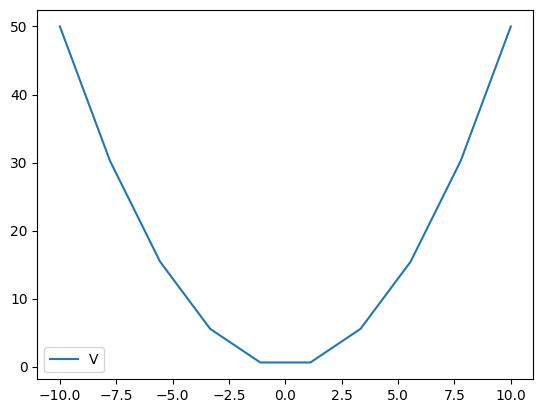

In [7]:
#Defining the potential well
def V(x):
    y = 0.5*x**2
    return y
x = torch.linspace(cfg.t0,cfg.tf,10).view(-1,1)
pot = V(x)
#scaled_pot = V_norm(x)

plt.plot(x,pot, label='V')
#plt.plot(x,scaled_pot, label='V_norm')
plt.legend()
plt.show()

In [8]:
#Defining the Frobenius norm
def frobenius_norm(G):
  I = torch.eye(G.shape[0], device = device, dtype = G.dtype)
  loss = torch.linalg.matrix_norm(G - I) #The frobenius norm
  return loss

#Defining the monotonicity_penalty
def monotonicity_penalty(E, margin = 0.0):
  diffs = E[:-1] - E[1:] + margin
  penalty = torch.relu(diffs).sum()
  return penalty

#Defining the cosine matrix using trapezoidal rule
def cosine_matrix(psi,x):
  psi_norm = torch.sqrt(torch.trapz(psi**2, x, dim=0))  # (k,)
  psi_normalized = psi / psi_norm  # (n, k)
  psi_prod = psi_normalized.unsqueeze(2) * psi_normalized.unsqueeze(1)  # (n, k, k)
  cos_matrix = torch.trapz(psi_prod, x, dim=0)
  return cos_matrix

### The NN Modules

In [10]:
#Defining group equivariant RqPINN
class equiRqNN(torch.nn.Module):
  def __init__(self,layers):
    super(equiRqNN,self).__init__()
    self.activation = torch.sin #The activation function

    #Defining the Layers
    self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)])

    #Initializing the weights
    for i in range(len(layers)-1):
      nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
      if i ==len(layers)-2:
        nn.init.zeros_(self.linears[i].bias.data) #Initializing the bias of the last layer to zeros
      else:
        nn.init.normal_(self.linears[i].bias.data)


  #Defining the forward pass
  def forward(self,x):
    if torch.is_tensor(x) != True:
      x = torch.from_numpy(x).float()
    a0 = torch.cat([x,-x], dim=0).view(2,-1,layers[0])
    #Implementing equivariance for l = 1
    z1 = self.linears[0](a0)
    a1 = self.activation(z1)

    #Implementing equivariance for 1 < l < L-1
    for i in range(1,len(self.linears)-1):
      z21 = self.linears[i](a1[0,:,:] - a1[1,:,:])
      z22 = self.linears[i](a1[1,:,:] - a1[0,:,:])
      z = torch.cat([z21,z22], dim = 0).view(2,-1,layers[i+1])
      a1 = self.activation(z)

    #Implementing equivariance for l = L
    out = self.linears[-1](a1[0,:,:] - a1[1,:,:])
    return out

### Checkpoint


#### Learning Rate Finder
We will find the best learning rate to start with

In [11]:
def common_train_step(NN,t_rand,t_sort,idx,vx, cfg):
    #Getting the parametric solution
    psi, sigma =parametricSolutions(t_rand,NN,cfg) #The forward pass
    psi = psi.to(device); sigma = sigma.to(device)

    # Compute second derivatives
    psi_x = dfx(psi, t_rand)
    psi_xx = dfx(psi_x, t_rand)

    psi_sort = psi[idx,:].to(device); psi_xx_sort = psi_xx[idx,:].to(device)
    
    L,E = hamEqs_Loss(t_sort,psi_sort,psi_xx_sort,vx)
    Loss = torch.nn.MSELoss()
    #Getting the losses after each forward pass
    #We can also add the monotonicty loss
    pde_loss = Loss(L,torch.zeros_like(L))  #The scaled pde_loss
    G = 10.0*cosine_matrix(psi_sort, t_sort)
    cosine_loss = frobenius_norm(G)
    return pde_loss, cosine_loss, E, sigma

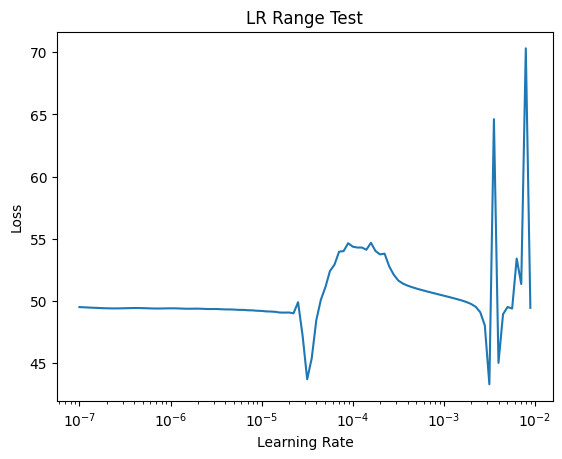

In [12]:
#We want to find the best lr for our defined model
model_lr = gaussqNN(cfg).to(device)
optimizer_lr = optim.Adam(model_lr.parameters(), lr=1e-7)

# Set up variables
x_lhs = torch.tensor(cfg.t0 + (cfg.tf - cfg.t0)*lhs(1,cfg.col_pts)).view(-1,1).float()
#x_lhs.requires_grad =True
losses = []
lrs = []

#Sorting and unsorting here
# Sort only the coordinates, without gradients
with torch.no_grad():
    t_squeezed = x_lhs.squeeze(-1)
    t_sort, idx = torch.sort(t_squeezed, dim=0)

x_lhs = x_lhs.to(device)
x_lhs.requires_grad = True
vx = V(t_sort.unsqueeze(1)).to(device)
t_sort = t_sort.to(device)

start_lr = 1e-7
end_lr = 1e-2
num_iter = 100
lr_mult = (end_lr / start_lr) ** (1/num_iter)

lr = start_lr

for iteration in range(num_iter):
    optimizer_lr.param_groups[0]['lr'] = lr

    optimizer_lr.zero_grad()
    pde_loss, cosine_loss,En,_= common_train_step(model_lr,x_lhs, t_sort,idx,vx,cfg)
    #monotone_loss = 10*monotonicity_penalty(En, margin = 1e-3)
    loss = pde_loss + cosine_loss #+ monotone_loss
    loss.backward()

    optimizer_lr.step()

    lrs.append(lr)
    losses.append(loss.item())

    lr *= lr_mult  # increase learning rate exponentially

# Plot the result
plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('LR Range Test')
plt.show()

It is important to note that the lr finder plot will change with different weights for the losses, so we should update accordingly

#### Training

In [13]:
model = gaussqNN(cfg).to(device)
model.to(device)
print(model)
#params = list(model.parameters())
#betas = [0.999, 0.9999]
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

gaussqNN(
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=5, bias=True)
  )
)


In [14]:
def nn_train(NN,t):
  En_history = [] #To store the eigenvalues as it is optimized
  loss_keys = ['pde_loss_hist','cos_loss_hist','total_loss_hist']
  loss_dic = {key: [] for key in loss_keys} #To store the losses
  #Sorting and unsorting here
  # Sort only the coordinates, without gradients
  t_sort, idx = torch.sort(t.squeeze(-1), dim=0)

  t_rand = t.to(device).requires_grad_(True).float()


  #Obtaining the potential
  vx = V(t_sort.unsqueeze(1)).to(device)

  #Dictionary to store the final training
  dic = {}

  stime = time.time()
  for iter in range(cfg.epochs + 1):
    optimizer.zero_grad()

    criteria_loss,cosine_loss,En,Sn = common_train_step(NN,t_rand,t_sort.to(device),idx,vx,cfg)
    #monotone_loss = 10.0*monotonicity_penalty(En, margin = 1e-3)
    total_loss = criteria_loss + cosine_loss #+ monotone_loss
  
    En_history.append(En.cpu().detach().numpy())
  
    loss_dic['pde_loss_hist'].append(criteria_loss.cpu().detach().numpy().item())
    loss_dic['cos_loss_hist'].append(cosine_loss.cpu().detach().numpy().item())
    if iter % 200 == 0:
      print('--------------------------------------------')
      print(f'Epoch: {iter}')
      print(f'En: {En_history[-1]}')
      print(f'sigmas: {Sn.detach().cpu().flatten().numpy()} ')
      print('--------------------------------------------')
      print('Total_loss: ',total_loss.item())
      print('pde_loss: ',criteria_loss.item())
      print('cos_loss: ',cosine_loss.item())


    #Backward propagation
    total_loss.backward()

    #Gradient Clipping
    torch.nn.utils.clip_grad_norm_(NN.parameters(), max_norm=10.0)

    #if iter % 100 == 0:
    #  for name, param in NN.named_parameters():
    #    if param.grad is not None:
    #      print(f'{name}: {param.grad.norm().item():.6f}')
    optimizer.step()
    #Scheduler
    scheduler.step()

    #Storing the loss after each iteration
    loss_dic['total_loss_hist'].append(total_loss.cpu().detach().numpy())

  #Storing the final eigenfunction
  dic[1] = copy.deepcopy(NN)


  ftime = time.time()
  ttime = (ftime - stime)/60
  print(f'Total training time is {ttime} minutes')
  return loss_dic, np.array(En_history), dic

In [15]:
x_lhs = torch.tensor(cfg.t0 + (cfg.tf - cfg.t0)*lhs(1,cfg.col_pts)).view(-1,1).float()
x_lhs.shape

torch.Size([200, 1])

In [16]:
Loss, eig_vals, qPINN = nn_train(model, x_lhs)

--------------------------------------------
Epoch: 0
En: [1.5082641 2.4690893 1.5215731 1.5095764 1.6074309]
sigmas: [0.98632604 1.744082   1.6349576  0.41514233 0.33439353] 
--------------------------------------------
Total_loss:  54.25237274169922
pde_loss:  9.047917366027832
cos_loss:  45.2044563293457
--------------------------------------------
Epoch: 200
En: [1.5097479 2.5946038 1.5430971 1.5024998 1.5955958]
sigmas: [0.9870671  1.7450831  1.6341238  0.4156229  0.33410138] 
--------------------------------------------
Total_loss:  48.07088851928711
pde_loss:  3.4284331798553467
cos_loss:  44.6424560546875
--------------------------------------------
Epoch: 400
En: [1.5108688 3.2579556 1.5628741 1.5005373 1.5552639]
sigmas: [0.9878017  1.7461939  1.633341   0.41607153 0.33412072] 
--------------------------------------------
Total_loss:  44.81901168823242
pde_loss:  1.8058922290802002
cos_loss:  43.013118743896484
--------------------------------------------
Epoch: 600
En: [1.51

In [17]:
tTest = torch.linspace(cfg.t0,cfg.tf,1200).view(-1,1)
tTest.requires_grad=True
t_net = tTest.detach().numpy()

psi,_ = parametricSolutions(tTest,qPINN[1].cpu(),cfg)
psi = psi.detach().numpy()

<>:24: SyntaxWarning: invalid escape sequence '\p'
<>:24: SyntaxWarning: invalid escape sequence '\p'
C:\Users\idris_oduola\AppData\Local\Temp\ipykernel_49988\3215202776.py:24: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel('$\psi(x)$', color='black')


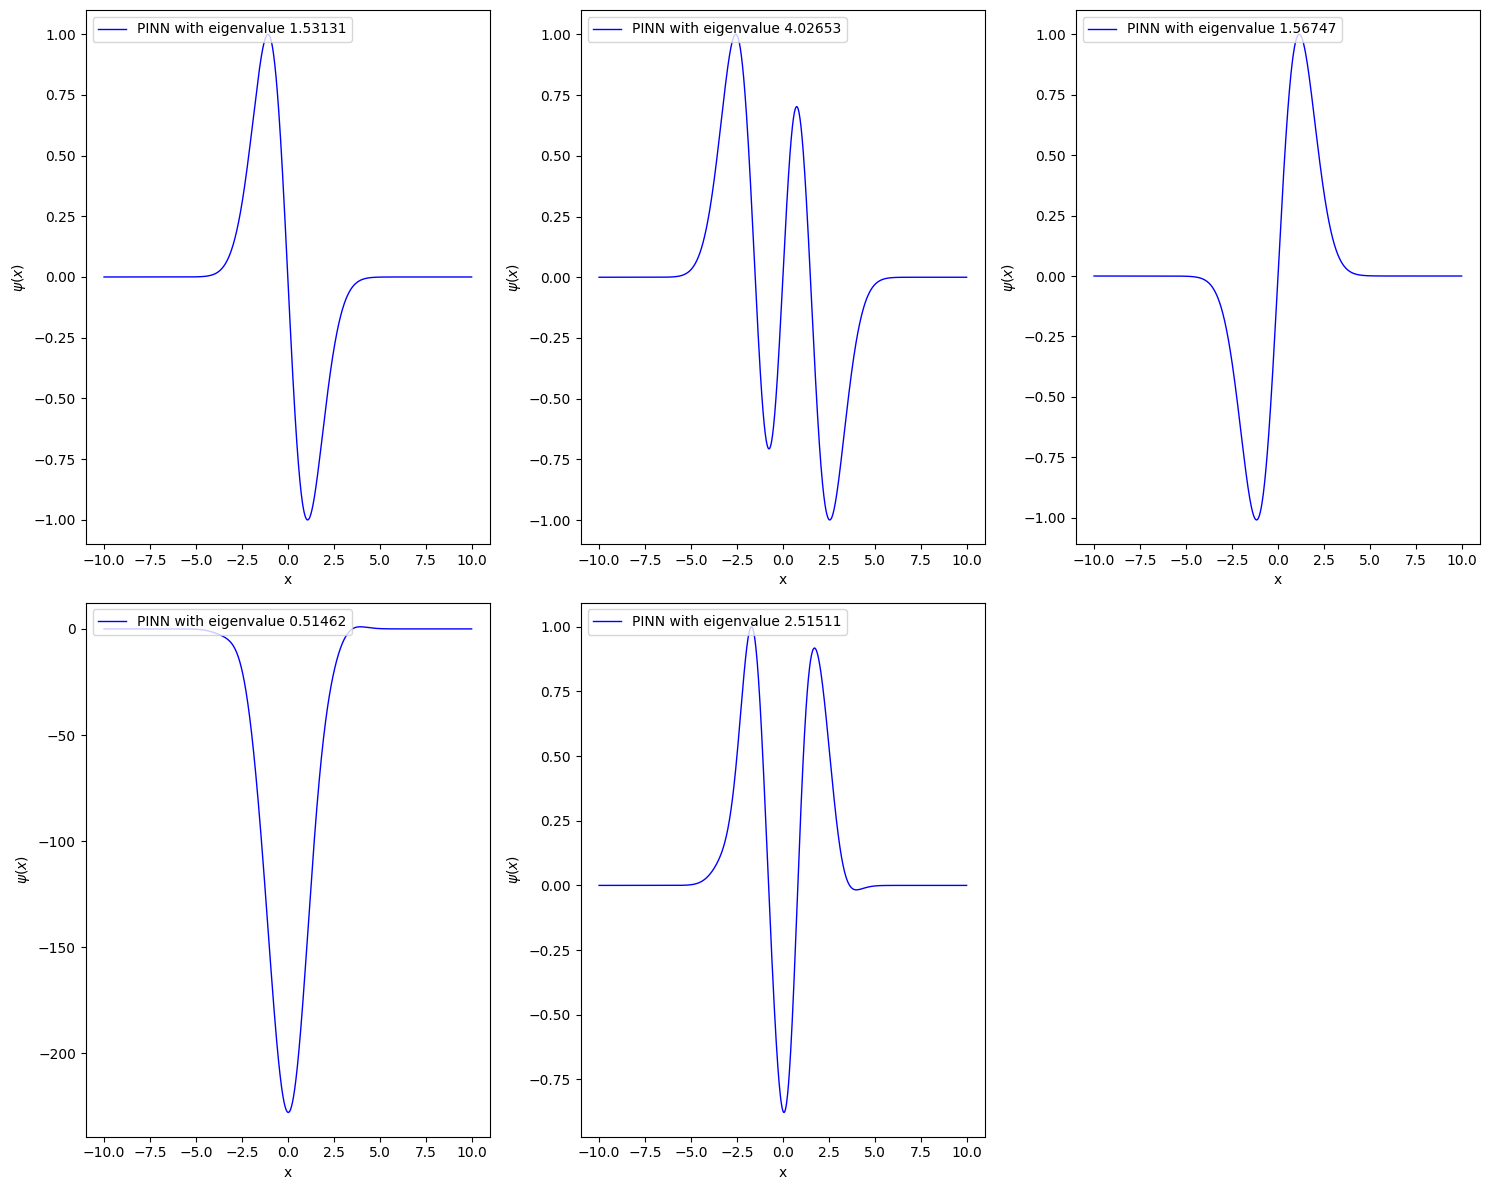

In [18]:
#Defining the number of rows and columns for the subplot grid
num_rows = 2
num_cols = 3

# Calculating the total number of subplots needed
total_subplots = eig_vals[-1].shape[0]

# Creating a figure and axes for the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))

# Iterating over eigenvalues and corresponding solutions
for index, eig in enumerate(eig_vals[-1,:total_subplots]):
    row_index = index // num_cols  # row index
    col_index = index % num_cols   # column index

    # Plot on the corresponding subplot
    #psi_i = psi[index] + En_counter[index]
    ax = axes[row_index, col_index]
    max_val = abs(max(psi[:,index]))
    ax.plot(t_net, psi[:,index]/max_val, color='blue', linewidth=1, label=f'PINN with eigenvalue {eig_vals[-1,index]:.5f}')
    #ax.plot(t_net, V(torch.tensor(t_net)))
    #ax.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=1)
    ax.set_xlabel('x', color='black')
    ax.set_ylabel('$\psi(x)$', color='black')
    ax.tick_params(axis='y', color='black')
    ax.legend(loc = 'upper left')

# Hiding the unused subplot
if total_subplots < num_rows * num_cols:
    for i in range(total_subplots, num_rows * num_cols):
        fig.delaxes(axes.flat[i])
# Adjusting layout to prevent overlap
plt.tight_layout()

plt.show()

In [19]:
G = psi.T @ psi
G

array([[ 5.8980011e+01, -1.4396700e-01, -3.8137402e+01,  4.8316107e-03,
         9.3085701e-03],
       [-1.4396700e-01,  8.3066881e-02,  1.6653357e-02, -7.8389457e-05,
        -7.0215297e-05],
       [-3.8137402e+01,  1.6653357e-02,  2.4758575e+01,  1.1617187e-03,
        -5.5971723e-03],
       [ 4.8316107e-03, -7.8389457e-05,  1.1617187e-03,  7.9787569e-03,
         4.9247446e-05],
       [ 9.3085701e-03, -7.0215297e-05, -5.5971723e-03,  4.9247446e-05,
         9.4423239e-04]], dtype=float32)

In [20]:
#checkpoint = {
#    "model_state_dict": model.state_dict(),
#    "losses": Loss
#}
#torch.save(checkpoint, 'checkpoints/ham_osci_gauss_with_trained_sigma2.pth')

## Training by batches sampled uniformly

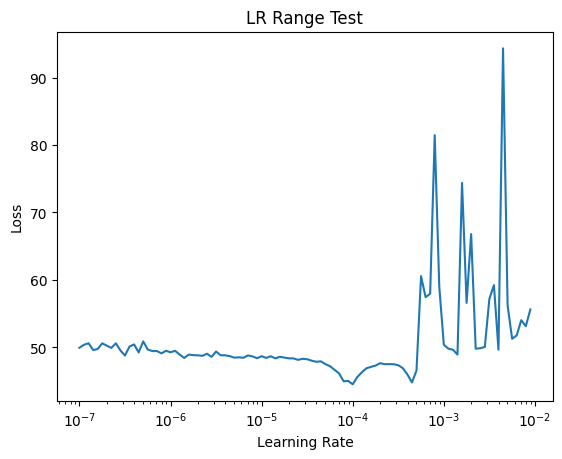

In [21]:
#We want to find the best lr for our defined model
model_lr = gaussqNN(cfg).to(device)
optimizer_lr = optim.Adam(model_lr.parameters(), lr=1e-7)

losses = []
lrs = []

start_lr = 1e-7
end_lr = 1e-2
num_iter = 100
lr_mult = (end_lr / start_lr) ** (1/num_iter)

lr = start_lr

for iteration in range(num_iter):
    optimizer_lr.param_groups[0]['lr'] = lr

    optimizer_lr.zero_grad()

    # Set up variables
    x_batch = np.random.uniform(cfg.t0, cfg.tf, (cfg.col_pts, 1))
    x_batch = torch.tensor(x_batch, dtype=torch.float32).to(device)

    #Sorting and unsorting here
    # Sort only the coordinates, without gradients
    with torch.no_grad():
        t_squeezed = x_batch.squeeze(-1)
        t_sort, idx = torch.sort(t_squeezed, dim=0)

    x_batch.requires_grad = True
    vx = V(t_sort.unsqueeze(1)).to(device)
    t_sort = t_sort.to(device)

    pde_loss, cosine_loss,En,_= common_train_step(model_lr,x_batch, t_sort,idx,vx,cfg)
    #monotone_loss = 10*monotonicity_penalty(En, margin = 1e-3)
    loss = pde_loss + cosine_loss #+ monotone_loss
    loss.backward()

    optimizer_lr.step()

    lrs.append(lr)
    losses.append(loss.item())

    lr *= lr_mult  # increase learning rate exponentially

# Plot the result
plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('LR Range Test')
plt.show()

In [22]:
def nn_train_batch(NN,cfg):
  En_history = [] #To store the eigenvalues as it is optimized
  loss_keys = ['pde_loss_hist','cos_loss_hist','total_loss_hist']
  loss_dic = {key: [] for key in loss_keys} #To store the losses
  #Dictionary to store the final training
  dic = {}

  stime = time.time()
  for iter in range(cfg.epochs + 1):
    optimizer_batch.zero_grad()

    # Set up variables
    t_batch = np.random.uniform(cfg.t0, cfg.tf, (cfg.col_pts, 1))
    t_batch = torch.tensor(t_batch, dtype=torch.float32).to(device)
    #Sorting and unsorting here
    # Sort only the coordinates, without gradients
    t_sort, idx = torch.sort(t_batch.squeeze(-1), dim=0)

    t_rand = t_batch.requires_grad_(True)


    #Obtaining the potential
    vx = V(t_sort.unsqueeze(1)).to(device)


    criteria_loss,cosine_loss,En,Sn = common_train_step(NN,t_rand,t_sort.to(device),idx,vx,cfg)
    #monotone_loss = 10.0*monotonicity_penalty(En, margin = 1e-3)
    total_loss = criteria_loss + cosine_loss #+ monotone_loss
  
    En_history.append(En.cpu().detach().numpy())
  
    loss_dic['pde_loss_hist'].append(criteria_loss.cpu().detach().numpy().item())
    loss_dic['cos_loss_hist'].append(cosine_loss.cpu().detach().numpy().item())
    if iter % 200 == 0:
      print('--------------------------------------------')
      print(f'Epoch: {iter}')
      print(f'En: {En_history[-1]}')
      print(f'sigmas: {Sn.detach().cpu().flatten().numpy()} ')
      print('--------------------------------------------')
      print('Total_loss: ',total_loss.item())
      print('pde_loss: ',criteria_loss.item())
      print('cos_loss: ',cosine_loss.item())


    #Backward propagation
    total_loss.backward()

    #Gradient Clipping
    torch.nn.utils.clip_grad_norm_(NN.parameters(), max_norm=10.0)

    #if iter % 100 == 0:
    #  for name, param in NN.named_parameters():
    #    if param.grad is not None:
    #      print(f'{name}: {param.grad.norm().item():.6f}')
    optimizer_batch.step()
    #Scheduler
    scheduler.step()
    if iter % 100 == 0: 
        current_lr = optimizer_batch.param_groups[0]['lr']
        print(f"Epoch {iter} | Current learning rate: {current_lr:.6e}")

    #Storing the loss after each iteration
    loss_dic['total_loss_hist'].append(total_loss.cpu().detach().numpy())

  #Storing the final eigenfunction
  dic[1] = copy.deepcopy(NN)


  ftime = time.time()
  ttime = (ftime - stime)/60
  print(f'Total training time is {ttime} minutes')
  return loss_dic, np.array(En_history), dic

In [23]:
model_batch = gaussqNN(cfg).to(device)
model_batch.to(device)
print(model_batch)
optimizer_batch = optim.Adam(model_batch.parameters(), lr=1e-5)
scheduler = CosineAnnealingLR(optimizer_batch, T_max=100, eta_min=1e-6)

gaussqNN(
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=5, bias=True)
  )
)


In [24]:
Loss_batch, eig_vals_batch, qPINN_batch = nn_train_batch(model_batch, cfg)

--------------------------------------------
Epoch: 0
En: [1.545849  1.501818  1.5334114 1.5960482 1.5253295]
sigmas: [0.47308078 0.7599459  0.985194   0.5194798  0.8022983 ] 
--------------------------------------------
Total_loss:  49.89691925048828
pde_loss:  1.7339056730270386
cos_loss:  48.16301345825195
Epoch 0 | Current learning rate: 9.997780e-06
Epoch 100 | Current learning rate: 1.002220e-06
--------------------------------------------
Epoch: 200
En: [1.9948087 1.4919199 1.5340168 1.5228717 1.526642 ]
sigmas: [0.4733491  0.76021725 0.9855787  0.51950777 0.80259305] 
--------------------------------------------
Total_loss:  45.940067291259766
pde_loss:  0.7132081985473633
cos_loss:  45.22686004638672
Epoch 200 | Current learning rate: 9.997780e-06
Epoch 300 | Current learning rate: 1.002220e-06
--------------------------------------------
Epoch: 400
En: [1.5725727 1.4998946 1.5310906 1.5427622 1.5273306]
sigmas: [0.47336313 0.7602804  0.985669   0.51950824 0.8026627 ] 
-------

<>:32: SyntaxWarning: invalid escape sequence '\p'
<>:32: SyntaxWarning: invalid escape sequence '\p'
C:\Users\idris_oduola\AppData\Local\Temp\ipykernel_49988\2388302696.py:32: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel('$\psi(x)$', color='black')


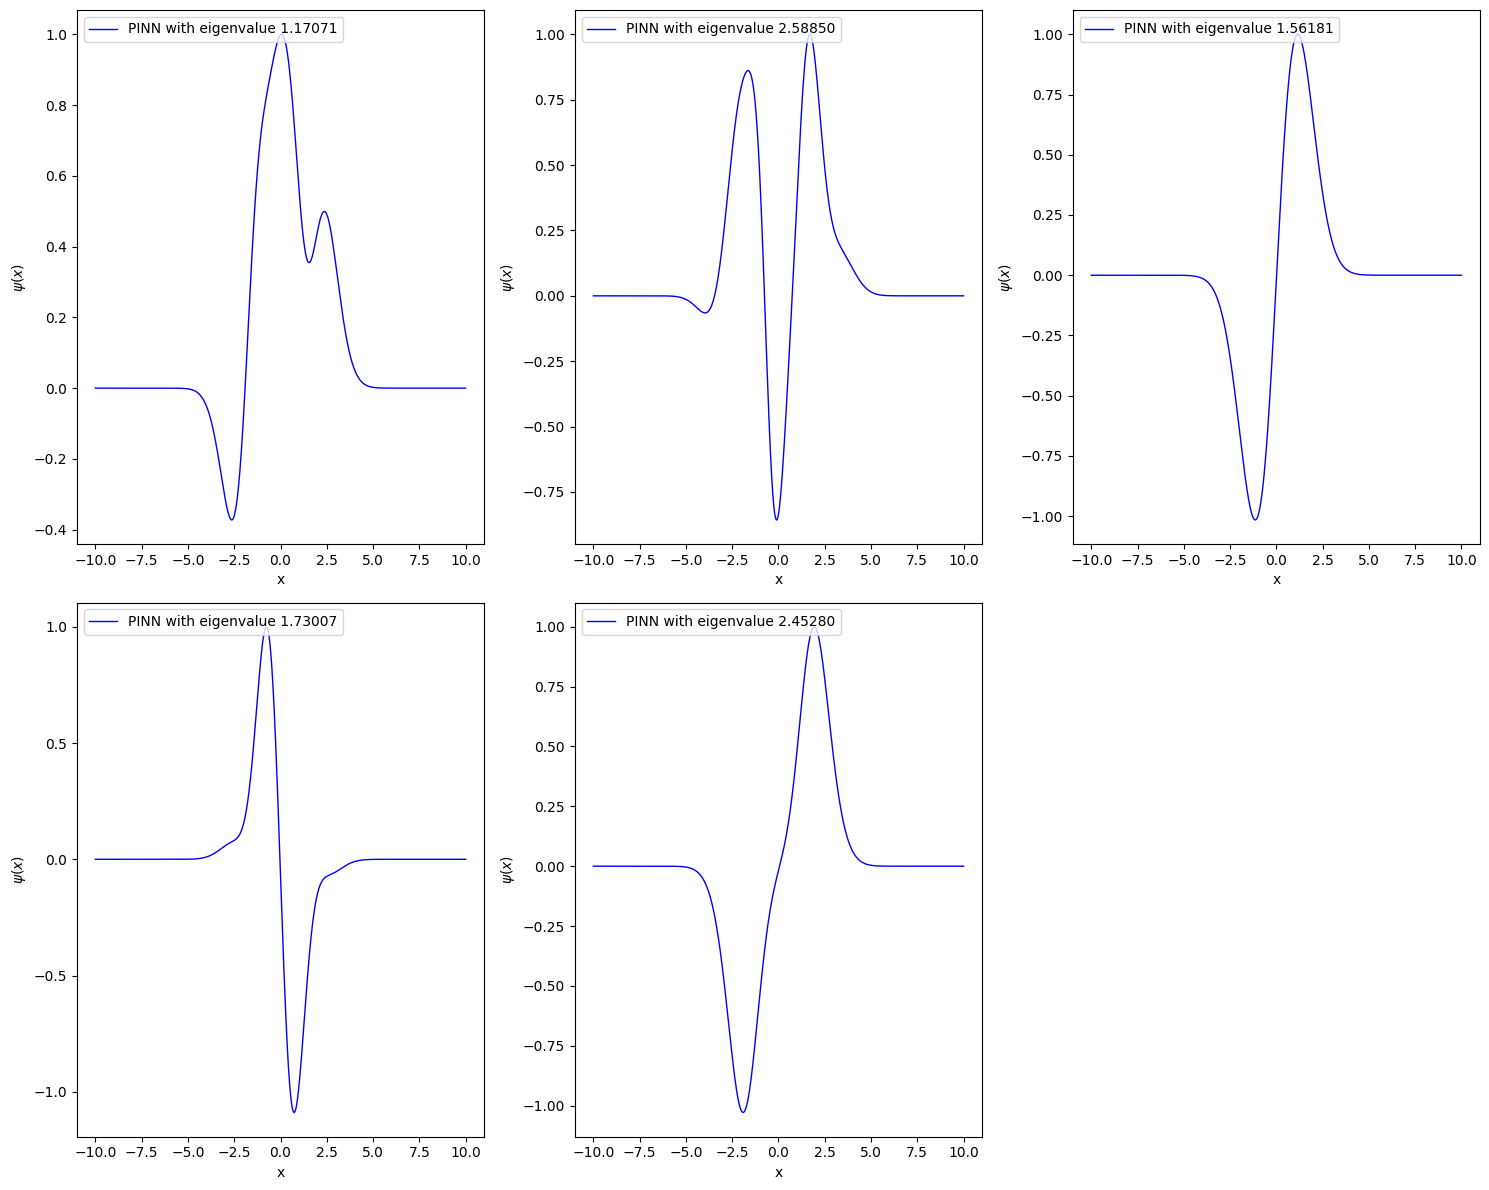

In [25]:
tTest = torch.linspace(cfg.t0,cfg.tf,1200).view(-1,1)
tTest.requires_grad=True
t_net = tTest.detach().numpy()

psi,_ = parametricSolutions(tTest,qPINN_batch[1].cpu(),cfg)
psi = psi.detach().numpy()


#Defining the number of rows and columns for the subplot grid
num_rows = 2
num_cols = 3

# Calculating the total number of subplots needed
total_subplots = eig_vals_batch[-1].shape[0]

# Creating a figure and axes for the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))

# Iterating over eigenvalues and corresponding solutions
for index, eig in enumerate(eig_vals_batch[-1,:total_subplots]):
    row_index = index // num_cols  # row index
    col_index = index % num_cols   # column index

    # Plot on the corresponding subplot
    #psi_i = psi[index] + En_counter[index]
    ax = axes[row_index, col_index]
    max_val = abs(max(psi[:,index]))
    ax.plot(t_net, psi[:,index]/max_val, color='blue', linewidth=1, label=f'PINN with eigenvalue {eig_vals_batch[-1,index]:.5f}')
    #ax.plot(t_net, V(torch.tensor(t_net)))
    #ax.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=1)
    ax.set_xlabel('x', color='black')
    ax.set_ylabel('$\psi(x)$', color='black')
    ax.tick_params(axis='y', color='black')
    ax.legend(loc = 'upper left')

# Hiding the unused subplot
if total_subplots < num_rows * num_cols:
    for i in range(total_subplots, num_rows * num_cols):
        fig.delaxes(axes.flat[i])
# Adjusting layout to prevent overlap
plt.tight_layout()

plt.show()